# Figure-creation notebook

This notebook contains the collection of scripts that were used to crete the figures of the thesis

## Figures related to the dataset

In [14]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def generate_statistics(dataset):
    num_images = len(dataset)
    class_distribution = {}
    for _, label in dataset:
        class_name = dataset.classes[label]
        if class_name in class_distribution:
            class_distribution[class_name] += 1
        else:
            class_distribution[class_name] = 1

    print("Number of images:", num_images)
    print("Class distribution:", class_distribution)

In [5]:
train_folder = "kaggle_brain_tumor/Training"
test_folder = "kaggle_brain_tumor/Testing"

# Define transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.ToTensor()  # Convert images to PyTorch tensors
])

# Create ImageFolder datasets
train_dataset = ImageFolder(root=train_folder, transform=transform)
test_dataset = ImageFolder(root=test_folder, transform=transform)

# Create DataLoader for efficient loading of data
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


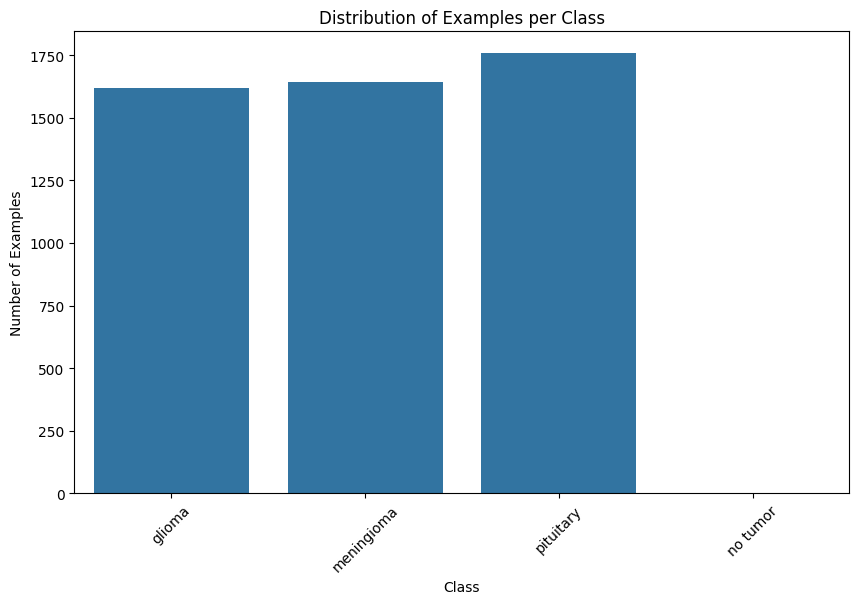

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the desired order of classes
class_order = ['glioma', 'meningioma', 'pituitary', 'no tumor']

# Get the class names
class_names = train_dataset.classes

# Initialize dictionaries to count the number of examples per class for train and test datasets
train_class_counts = {class_name: 0 for class_name in class_names}
test_class_counts = {class_name: 0 for class_name in class_names}

# Iterate over the train dataset and count examples for each class
for _, label in train_dataset:
    train_class_counts[class_names[label]] += 1

# Iterate over the test dataset and count examples for each class
for _, label in test_dataset:
    test_class_counts[class_names[label]] += 1

# Combine the counts from train and test datasets
combined_class_counts = {class_name: train_class_counts[class_name] + test_class_counts[class_name] for class_name in class_names}




In [29]:
combined_class_counts

{'glioma': 1621, 'meningioma': 1645, 'notumor': 2000, 'pituitary': 1757}

In [30]:
correct_order={'glioma': 1621, 'meningioma': 1645, 'pituitary': 1757, 'notumor': 2000}

C:\Users\Csabi\AppData\Local\Temp\ipykernel_23448\1449930866.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(correct_order.keys()), y=list(correct_order.values()), palette="viridis")


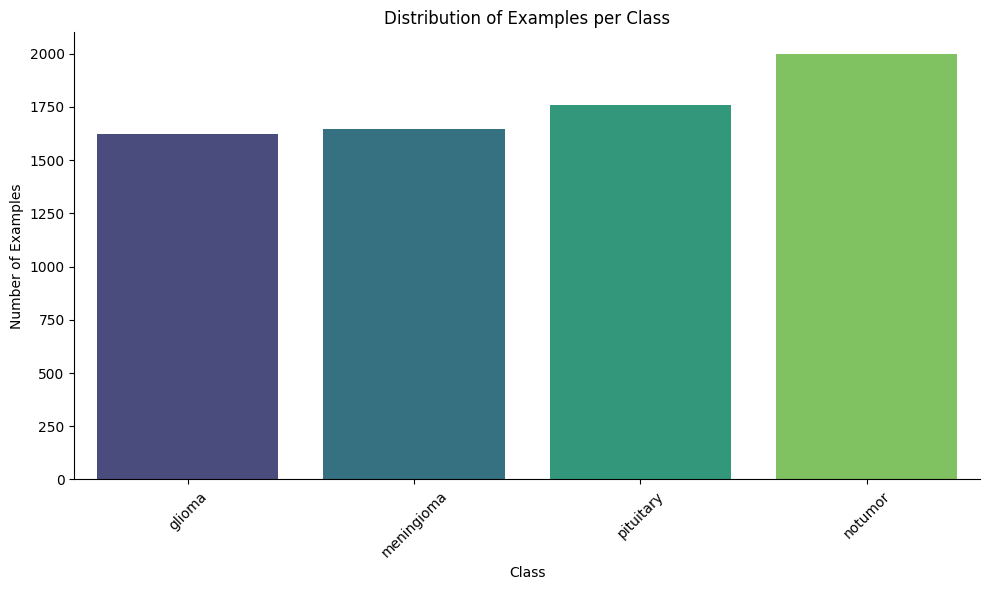

<Figure size 640x480 with 0 Axes>

In [34]:
# Plot the distribution of combined counts with the specified order
plt.figure(figsize=(10, 6))
sns.barplot(x=list(correct_order.keys()), y=list(correct_order.values()), palette="viridis")
plt.title('Distribution of Examples per Class')
plt.xlabel('Class')
plt.ylabel('Number of Examples')
plt.xticks(rotation=45)
sns.despine()  # Remove top and right spines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('class_distribution_combined.png')
plt.show()


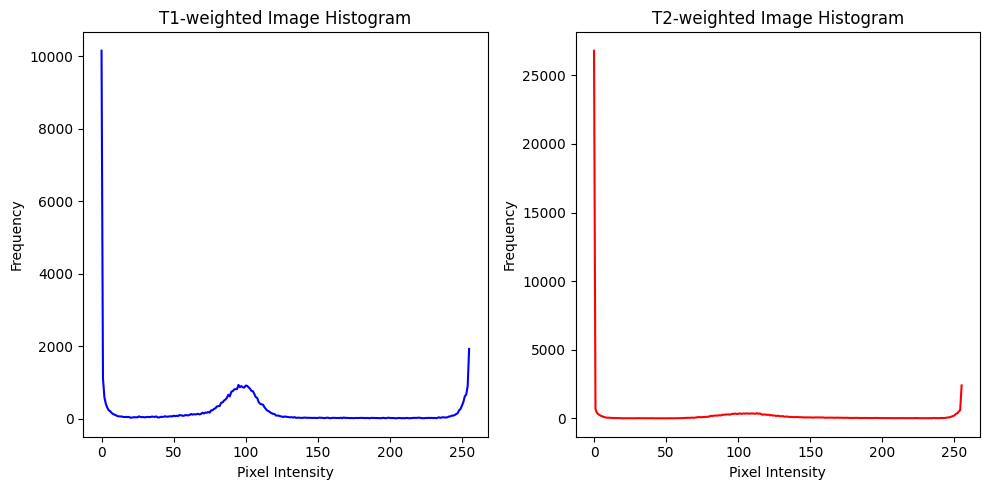

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load T1-weighted and T2-weighted MRI images
t1_image = cv2.imread('kaggle_brain_tumor/Testing/notumor/Te-no_0010.jpg')
t2_image = cv2.imread('kaggle_brain_tumor/Testing/notumor/Te-no_0011.jpg')

# Convert images to grayscale
t1_gray = cv2.cvtColor(t1_image, cv2.COLOR_BGR2GRAY)
t2_gray = cv2.cvtColor(t2_image, cv2.COLOR_BGR2GRAY)

# Calculate pixel intensity histograms
t1_hist = cv2.calcHist([t1_gray], [0], None, [256], [0, 256])
t2_hist = cv2.calcHist([t2_gray], [0], None, [256], [0, 256])

# Plot histograms
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t1_hist, color='b')
plt.title('T1-weighted Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.plot(t2_hist, color='r')
plt.title('T2-weighted Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [24]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


# Resize Images to Ensure Same Size
min_height = min(t1_image.shape[0], t2_image.shape[0])
min_width = min(t1_image.shape[1], t2_image.shape[1])
t1_image = cv2.resize(t1_image, (min_width, min_height))
t2_image = cv2.resize(t2_image, (min_width, min_height))

# Reshape Images to 1D Arrays
t1_flat = t1_image.flatten().reshape(-1, 1)
t2_flat = t2_image.flatten().reshape(-1, 1)

# Concatenate Features
features = np.concatenate((t1_flat, t2_flat), axis=1)

# K-means Clustering with Different Cluster Numbers
k_range = range(2, 3)
scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    scores.append(silhouette_score(features, kmeans.labels_))

# Choose the Best K Based on Silhouette Score
best_k = k_range[np.argmax(scores)]

# Cluster Images
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(features)
cluster_labels = kmeans.labels_

# Plot Clustered Images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(t1_image, cmap='gray')
plt.title('T1-weighted MRI')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(t2_image, cmap='gray')
plt.title('T2-weighted MRI')
plt.axis('off')
plt.show()

# Plot K-means Clustering Results
plt.figure(figsize=(8, 6))
plt.scatter(features[:, 0], features[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-means Clustering')
plt.xlabel('Pixel Intensity (T1-weighted)')
plt.ylabel('Pixel Intensity (T2-weighted)')
plt.colorbar(label='Cluster')
plt.show()


d:\Conda\envs\computer_vision_assignment_1\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyboardInterrupt: 

## ADHD person level accuracy

In [194]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch.utils.data import random_split
from torchvision import models, transforms, datasets
from torchvision.models import ResNet50_Weights
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, f1_score, recall_score
import numpy as np
import itertools
import os
import torch
import matplotlib.pyplot as plt
import math
import pandas as pd
import warnings

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [101]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.file_list = [(file, c) for c in self.classes for file in os.listdir(os.path.join(self.root_dir, c))]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        sample = self.file_list[idx]
        image = Image.open(os.path.join(self.root_dir, sample[1], sample[0])).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, int(self.file_list[idx][1]), self.file_list[idx][0]

In [104]:
os.listdir('../data/ADHD/slice/adhd')

['0', '1']

In [105]:
device = 'cuda:0'

In [106]:
class ZScoreNormalization(object):
    def __call__(self, tensor):
        mean = torch.mean(tensor)
        std = torch.std(tensor)
        return (tensor - mean) / std

In [107]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    ZScoreNormalization(),
])


In [108]:
ds = CustomImageDataset('../data/ADHD/slice/adhd', transform=test_transform)

generator = torch.Generator().manual_seed(42)
splits = random_split(ds, [0.8, 0.1, 0.1], generator=generator)
test_loader = DataLoader(splits[2], batch_size=256, shuffle=False)

In [109]:
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(ds.classes))

model.load_state_dict(torch.load('../models/mri_pretrained_adhd_axial_full_2024_03_31_01_05_34_188305/checkpoints/best_checkpoint.pt'))
model = model.to(device)

In [110]:
def calculate_metrics(epoch,metric_type, loss, labels, predictions):
    return {
        "epoch": [epoch],
        "metric_type": [metric_type],
        "accuracy": [accuracy_score(labels, predictions)],
        "precision": [precision_score(labels, predictions, average="weighted")],
        "recall": [recall_score(labels, predictions, average="weighted")],
        "f1": [f1_score(labels, predictions, average="weighted")],
        "loss" : [loss]
    }

def log_metrics(writer, metrics):
    # Log metrics to TensorBoard
    for key, value in metrics.items():
        if key != "epoch" and key != "metric_type":  # Exclude non-numeric values
            writer.add_scalar(f"{metrics['metric_type'][0]}/{key}", value[0], metrics['epoch'][0] + 1)

def plot_confusion_matrix(y_true, y_pred, classes, output_path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(output_path, 'confusion_matrix.jpg'))
    plt.show()

def visualize_metrics(metrics_df, output_path, title):
    # Define the metrics to visualize
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1']

    # Create a grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(12, 6.5))
    axes = axes.flatten()

    # Plot each metric in a subplot
    for i, metric in enumerate(metrics):
        ax = axes[i]
        sns.lineplot(data=metrics_df, x='epoch', y=metric, hue='metric_type', style='metric_type', ax=ax)
        ax.set_title(metric.capitalize())
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        #ax.legend(['Train', 'Validation'], loc='best')

    # Adjust layout
    plt.suptitle(f'Training results\n{title}')
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, 'metrics.jpg'))

In [126]:


def evaluate_model_with_misclassified_plot(model, val_loader, device, output_path, ds, num_images_to_plot=5):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_test_predictions = []
    all_test_labels = []
    misclassified_images = []
    names = []

    with torch.no_grad():
        for idx, (inputs, labels, name) in enumerate(val_loader):
            inputs, labels = inputs.to(device), torch.tensor(labels).to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)


            names.extend([*name])

            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_test_predictions.extend(predicted.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

            misclassified_mask = predicted != labels
            misclassified_indices = (idx * val_loader.batch_size) + torch.nonzero(misclassified_mask).view(-1)
            misclassified_images.extend(misclassified_indices.tolist())

    data = {'predictions': all_test_predictions, 'actual': all_test_labels, 'names': names}

    # Create a DataFrame
    result_df = pd.DataFrame(data)

    test_loss = test_loss / len(val_loader)
    plot_confusion_matrix(all_test_labels, all_test_predictions, classes=ds.classes, output_path=output_path)
    test_metrics = calculate_metrics(1, 'test', test_loss, all_test_labels, all_test_predictions)
    
    # Save misclassified images
    plot_misclassified_images(val_loader.dataset, misclassified_images, num_images_to_plot)
    plt.savefig(os.path.join(output_path, "misclassified_images.png"))  # Save the plot
    
    return test_metrics, result_df

def plot_misclassified_images(dataset, misclassified_indices, max_images_per_column=3):
    """
    Plots misclassified images along with their true and predicted labels.
    
    Parameters:
        dataset (torch.utils.data.Dataset): Dataset object.
        misclassified_indices (list): List of indices of misclassified images.
        max_images_per_column (int): Maximum number of images to plot per column.
    """
    num_images = len(misclassified_indices)
    num_columns = min(math.ceil(num_images / max_images_per_column), 3)
    num_rows = math.ceil(num_images / num_columns)
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(5 * num_columns, 5 * num_rows))
    for i, idx in enumerate(misclassified_indices):
        row_idx = i % num_rows
        col_idx = i // num_rows
        
        img, true_label, name = dataset[idx]
        axes[row_idx, col_idx].imshow(img.permute(1, 2, 0))  # Assuming img is a torch tensor (C, H, W)
        predicted_label = model(img.unsqueeze(0).to(device)).argmax().item()  # Assuming model is available
        axes[row_idx, col_idx].set_title(f'True: {ds.classes[true_label]}, Predicted: {ds.classes[predicted_label]}\n{name}')
        axes[row_idx, col_idx].axis('off')
        
    # Hide empty subplots
    for i in range(num_images, num_rows * num_columns):
        row_idx = i % num_rows
        col_idx = i // num_rows
        axes[row_idx, col_idx].axis('off')
    
    plt.tight_layout()
    plt.show()




C:\Users\Csabi\AppData\Local\Temp\ipykernel_23996\2732281378.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = inputs.to(device), torch.tensor(labels).to(device)


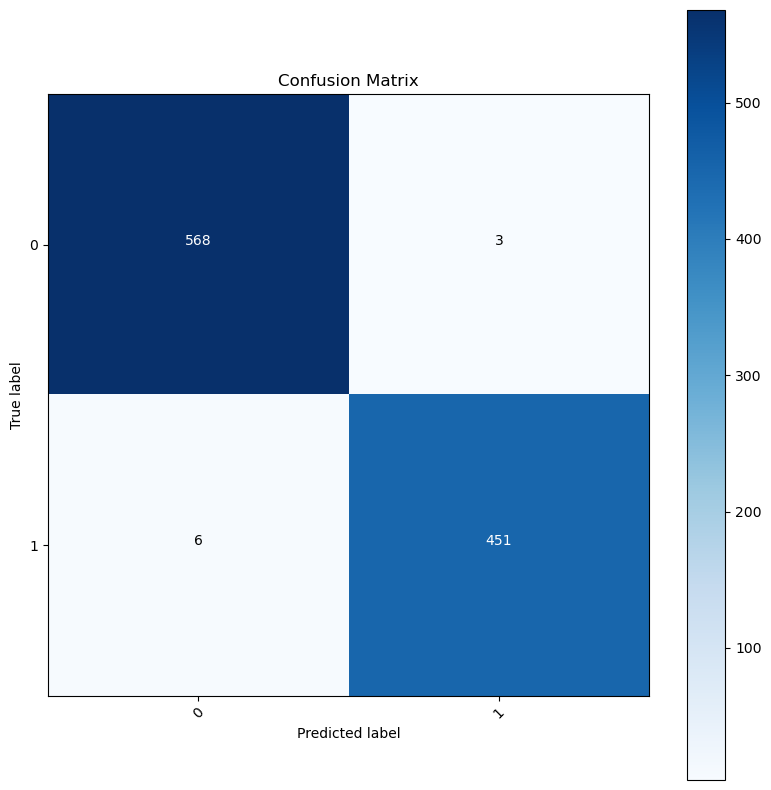

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


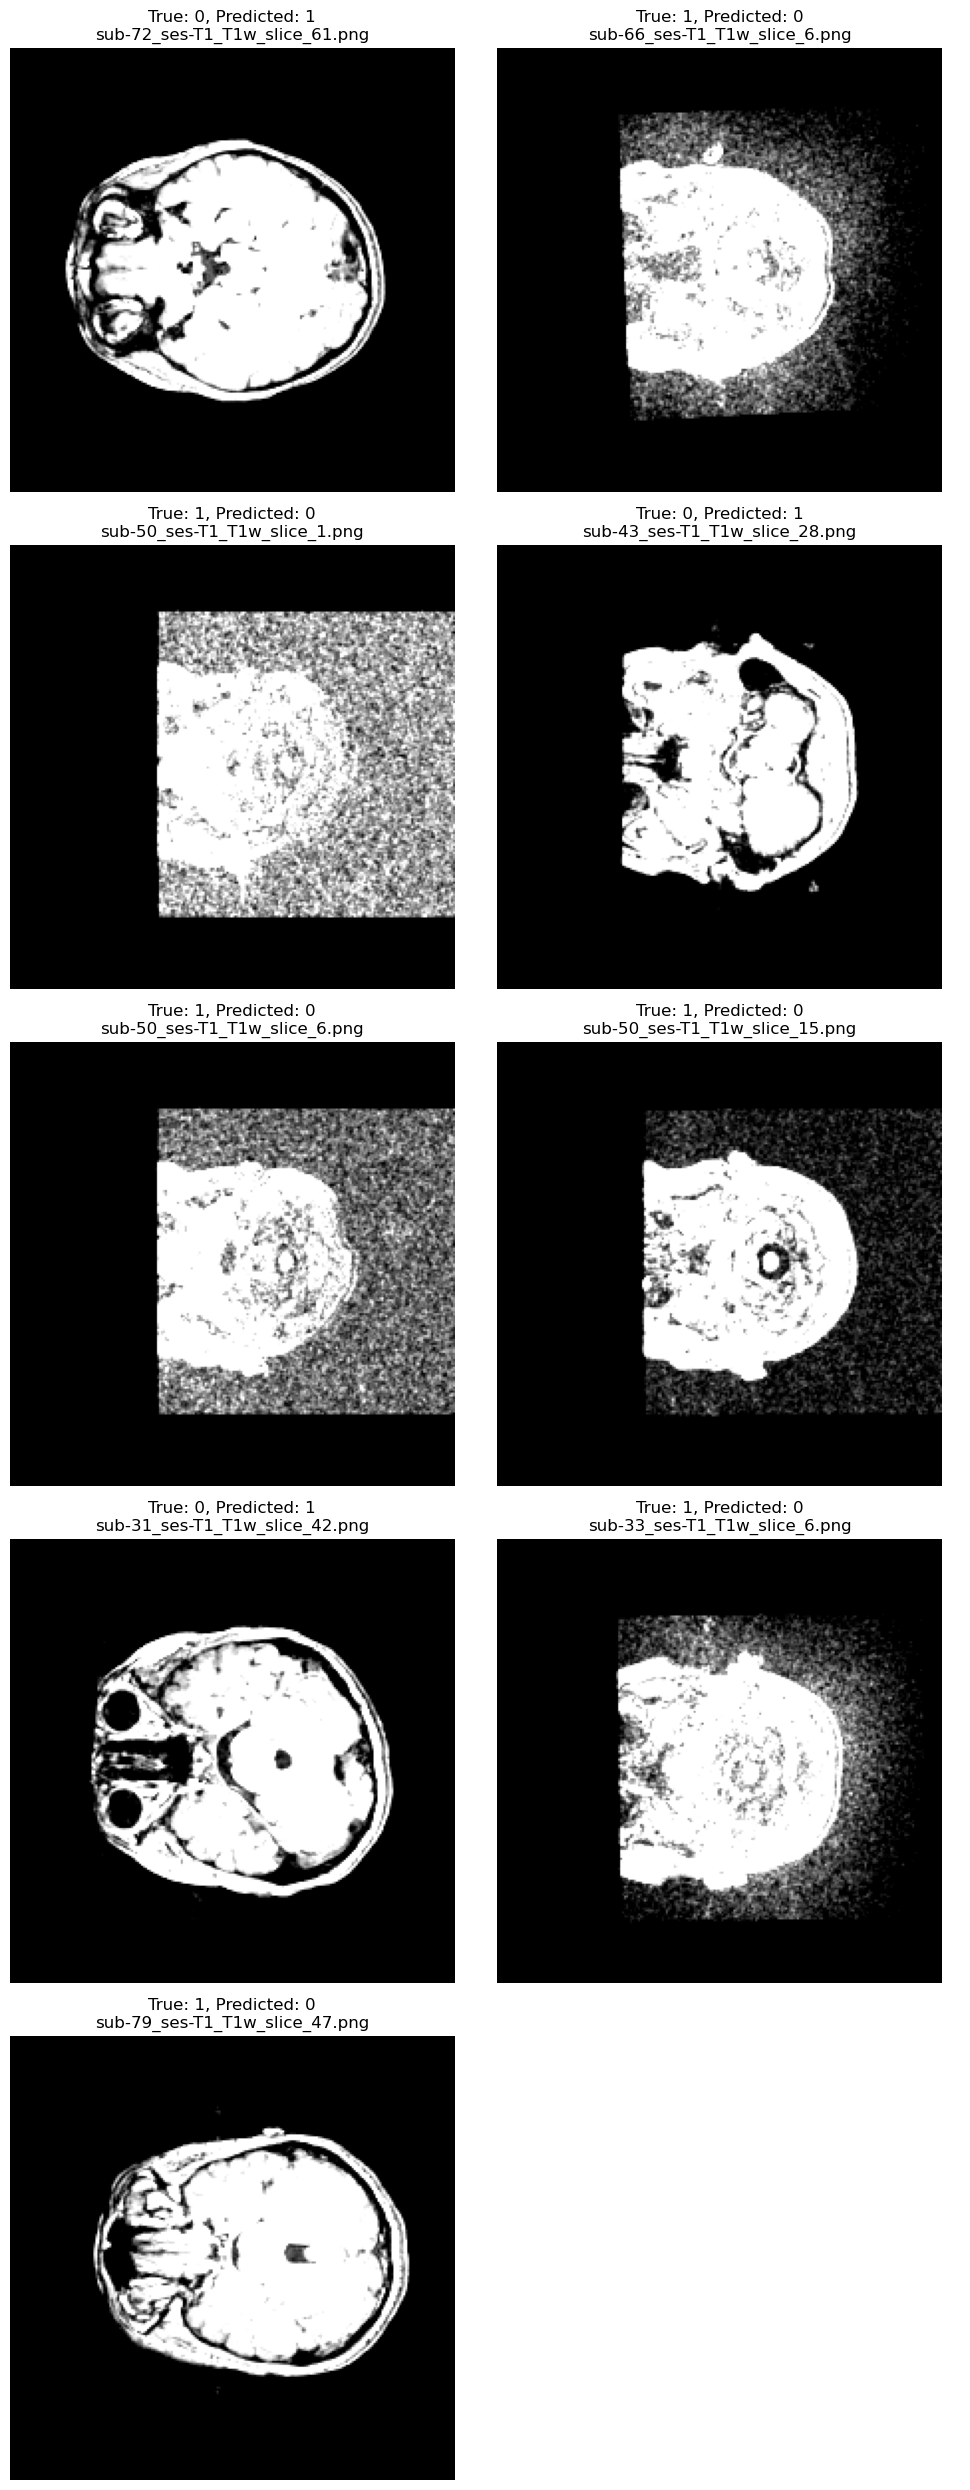

<Figure size 640x480 with 0 Axes>

In [162]:
metrics, model_res = evaluate_model_with_misclassified_plot(model, test_loader, device, 'output', ds, 5)


In [163]:
model_res['person'] = model_res.names.apply(lambda x: x.split('_')[0])
model_res['slice'] = model_res.names.apply(lambda x: x.split('slice_')[1].split('.')[0])


In [211]:
file_path = '../data/ADHD/participants.tsv'
df = pd.read_csv(file_path, sep='\t')
df = df.drop(columns=['age_ses-T2',
       'SLD_datetime', 'SLI_datetime', 'SSD_datetime',
       'SSI_datetime', 'VLD_datetime', 'VLI_datetime', 'VSD_datetime',
       'VSI_datetime'])

In [174]:
preds = model_res.merge(df, left_on='person', right_on = 'participant_id', how='left')
preds = preds.drop(columns=['participant_id'])
preds['ADHD_medication'] = ~preds.ADHD_medication.apply(pd.isna)

In [213]:
df[df.ADHD_diagnosis == 1]

,participant_id,age_ses-T1,sex,handedness,ADHD_diagnosis,ADHD_medication,race,ethnicity
0,sub-01,10.77,1,2.0,1,Metadate daily,3.0,2.0
1,sub-02,11.90,1,2.0,1,Concerta on school days,5.0,1.0
3,sub-04,9.22,1,2.0,1,Vvyanse once,6.0,2.0
4,sub-05,8.59,1,2.0,1,"focalin - 20 mg, Monday - Friday",3.0,2.0
5,sub-06,11.85,1,2.0,1,NaN,5.0,2.0
7,sub-08,9.34,1,2.0,1,NaN,5.0,2.0
8,sub-09,11.85,1,2.0,1,Focalin,7.0,NaN
9,sub-10,10.77,1,2.0,1,Focalin,3.0,2.0
10,sub-11,11.38,1,2.0,1,Focalin daily,5.0,1.0
11,sub-12,10.10,1,2.0,1,Concerta,5.0,1.0


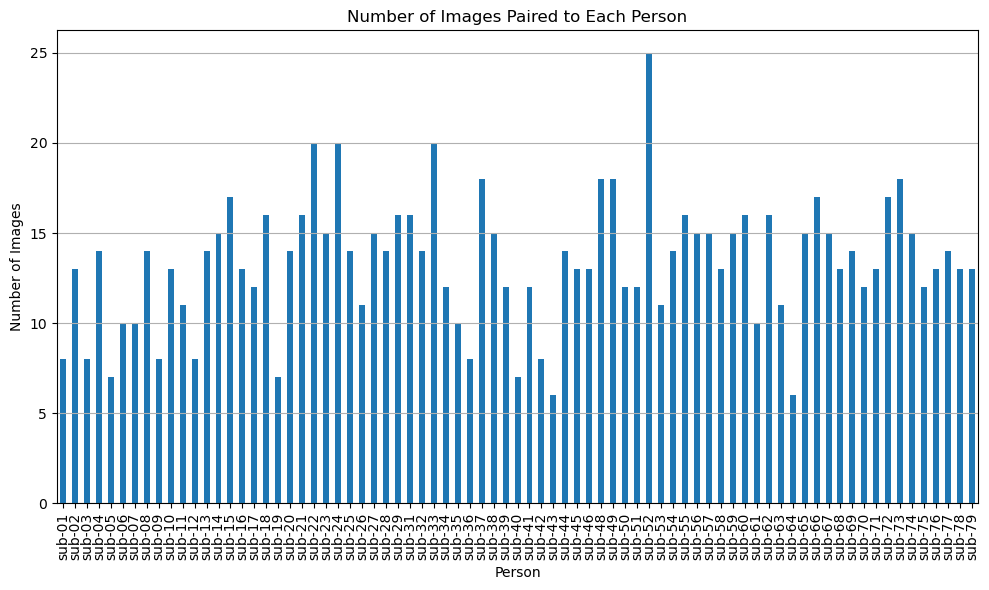

In [146]:
person_counts = preds['person'].value_counts().sort_index()

# Plot the bar plot
plt.figure(figsize=(10, 6))
person_counts.plot(kind='bar')
plt.title('Number of Images Paired to Each Person')
plt.xlabel('Person')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

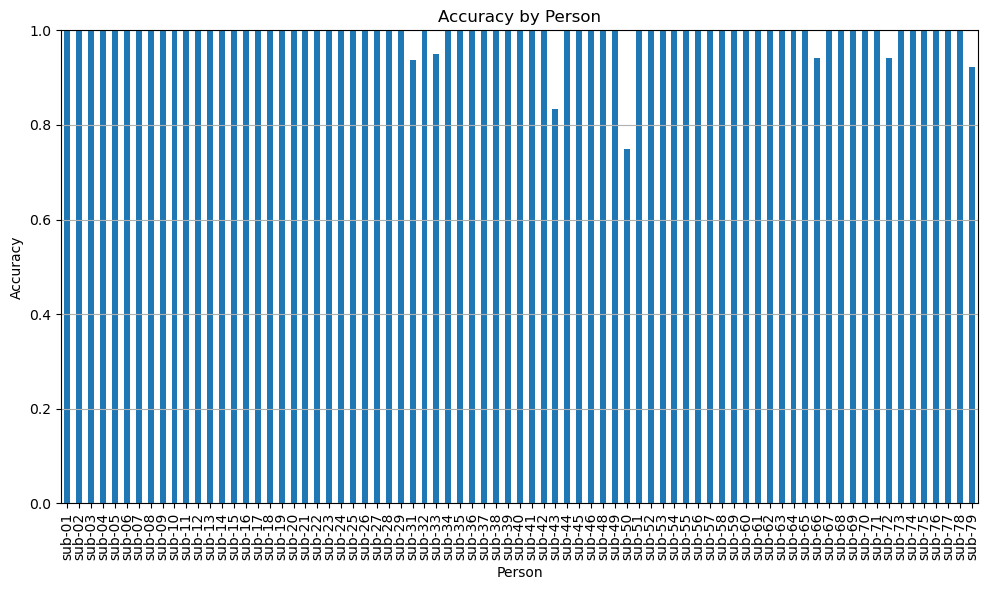

In [142]:
# Calculate accuracy for each row
preds['Correct'] = preds['predictions'] == preds['actual']
preds['Accuracy'] = preds['Correct'].astype(int)

# Calculate accuracy by person
accuracy_by_person = preds.groupby('person')['Accuracy'].mean()

# Plot the bar plot
plt.figure(figsize=(10, 6))
accuracy_by_person.plot(kind='bar')
plt.title('Accuracy by Person')
plt.xlabel('Person')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
plt.ylim(0, 1)  # Setting y-axis limits to range from 0 to 1
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

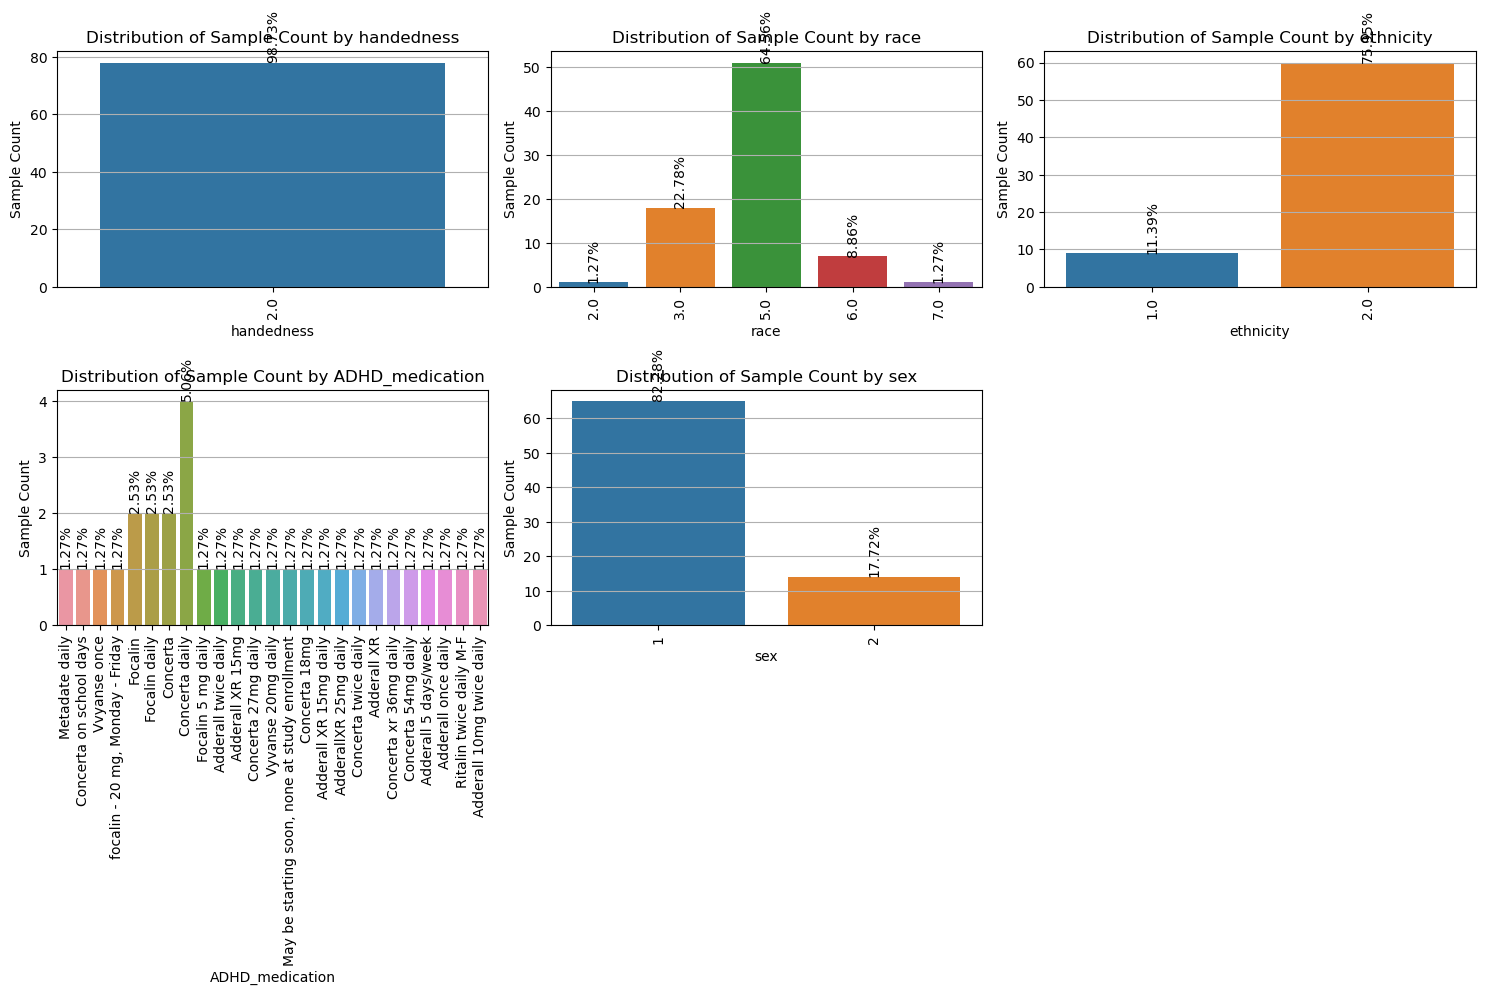

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the columns you want to observe
columns_to_observe = ['handedness', 'race', 'ethnicity', 'ADHD_medication', 'sex']

# Create a single grid of plots
plt.figure(figsize=(15, 10))

for i, col in enumerate(columns_to_observe, 1):
    plt.subplot(2, 3, i)
    ax = sns.countplot(x=col, data=df)
    plt.title(f'Distribution of Sample Count by {col}')
    plt.xlabel(col)
    plt.ylabel('Sample Count')
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    
    # Add percentage values on top of each bar
    total = len(df[col])
    for p in ax.patches:
        height = p.get_height()
        percentage = f'{100 * height / total:.2f}%'
        ax.text(p.get_x() + p.get_width() / 2., height, percentage, ha='center', va='bottom', rotation=90)

plt.tight_layout()
plt.show()


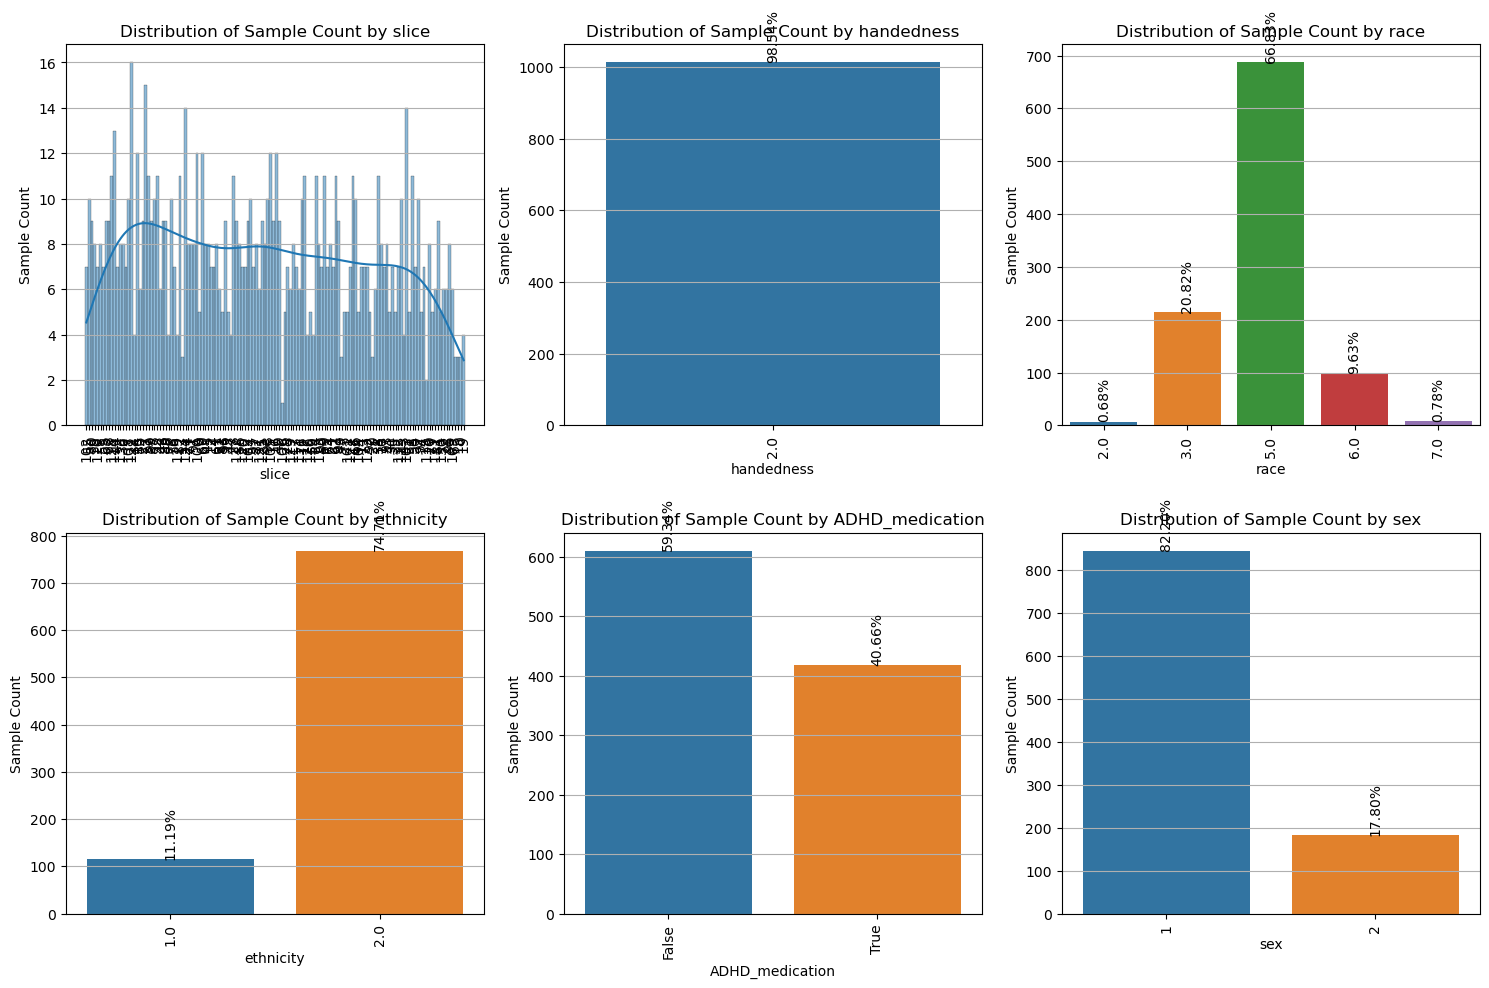

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the columns you want to observe
columns_to_observe = ['slice','handedness', 'race', 'ethnicity', 'ADHD_medication', 'sex']

# Create a single grid of plots
plt.figure(figsize=(15, 10))

for i, col in enumerate(columns_to_observe, 1):
    plt.subplot(2, 3, i)
    if col == 'slice':
        ax = sns.histplot(x=col, data=preds, kde=True)
    else:
        ax = sns.countplot(x=col, data=preds)
    plt.title(f'Distribution of Sample Count by {col}')
    plt.xlabel(col)
    plt.ylabel('Sample Count')
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    
    # Add percentage values on top of each bar
    total = len(preds[col])
    for p in ax.patches:
        height = p.get_height()
        percentage = f'{100 * height / total:.2f}%'
        if col !='slice':
            ax.text(p.get_x() + p.get_width() / 2., height, percentage, ha='center', va='bottom',rotation=90)

plt.tight_layout()
plt.show()


In [206]:
len(df)

79

In [207]:
len(ds)

10289

In [205]:
len(preds)

1028

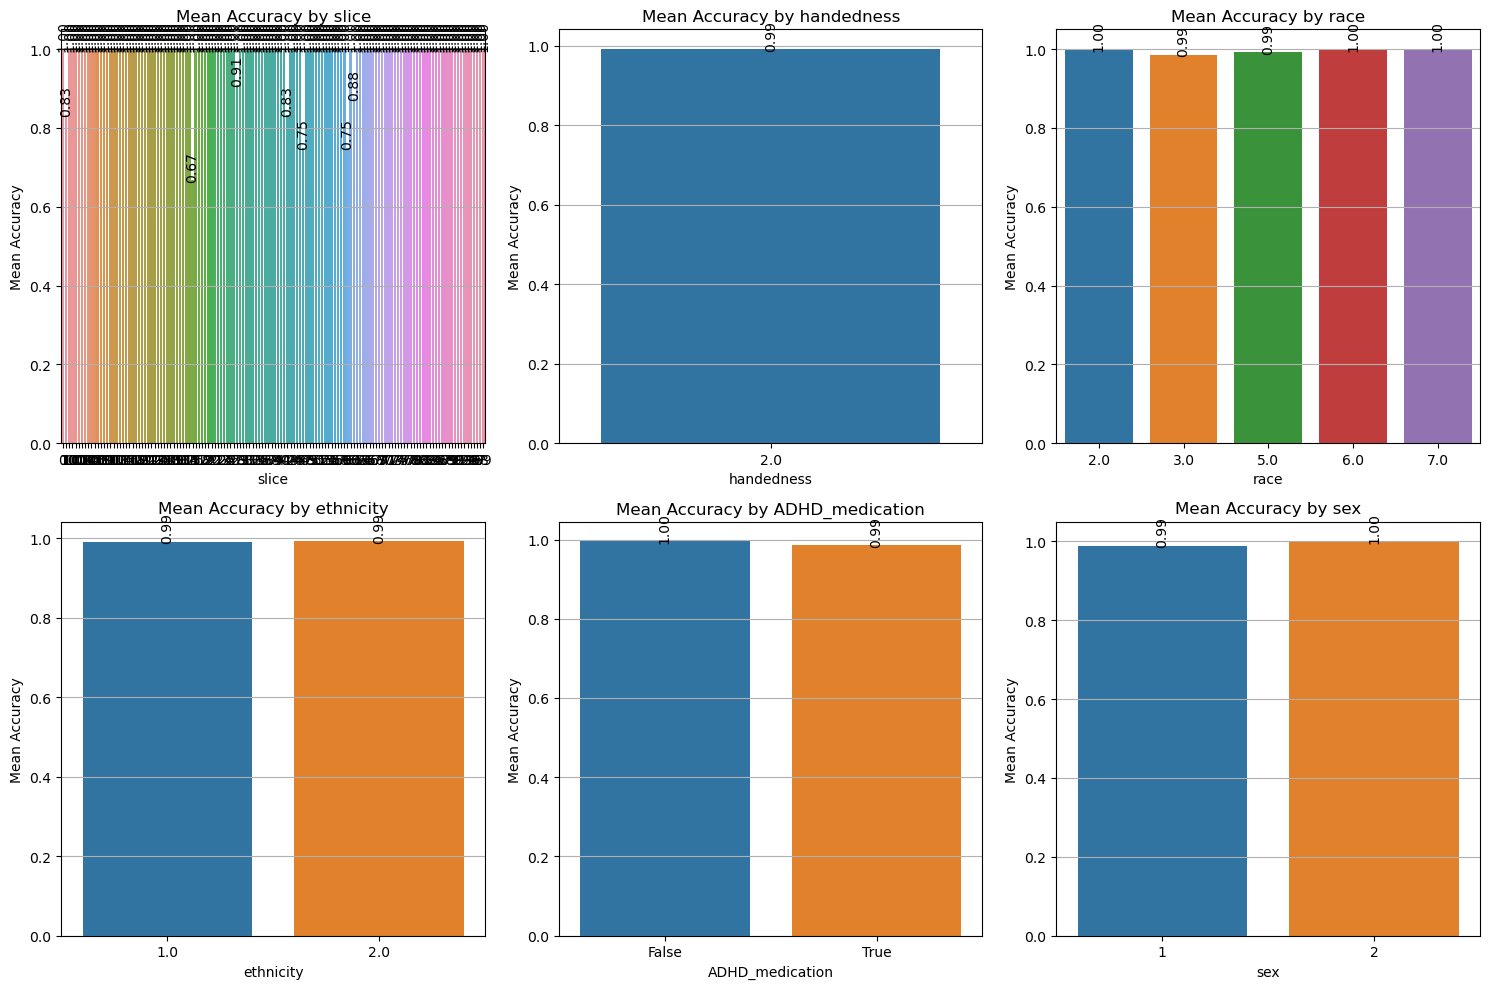

In [214]:
# Calculate accuracy for each row
preds['Correct'] = preds['predictions'] == preds['actual']
preds['Accuracy'] = preds['Correct'].astype(int)

# Define the columns you want to observe
columns_to_observe = ['slice', 'handedness', 'race', 'ethnicity', 'ADHD_medication', 'sex']

# Create a grid of plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate over columns
for i, col in enumerate(columns_to_observe):
    # Calculate mean accuracy for each group
    accuracy_by_group = preds.groupby(col)['Accuracy'].mean().reset_index()

    # Plot bar plot
    sns.barplot(x=col, y='Accuracy', data=accuracy_by_group, ax=axes[i])
    axes[i].set_title(f'Mean Accuracy by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Mean Accuracy')
    axes[i].grid(axis='y')

    # Annotate each bar with its value
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points' )

# Remove empty subplot(s) if the number of columns is less than 6
if len(columns_to_observe) < 6:
    for j in range(len(columns_to_observe), 6):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Accuracy by slice

In [19]:
from tqdm import tqdm  # Import tqdm
import os
import torch
from torchvision import transforms
from torchvision.models import resnet50
from PIL import Image
import pandas as pd

# Define paths and hyperparameters
model_path = "../models/mri_pretrained_resnet.pt"  # Replace with your weight file path
image_folder = "../data/ADHD/slice/3d_sorted/test/1"  # Replace with your image folder path
num_classes = 2  # Adjust based on your classification problem

class ZScoreNormalization(object):
    def __call__(self, tensor):
        mean = torch.mean(tensor)
        std = torch.std(tensor)
        return (tensor - mean) / std

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    ZScoreNormalization(),
])

# Load pre-trained model and modify classifier head
model = resnet50(pretrained=True)


num_ftrs = model.fc.in_features  # Get number of input features for the classifier head
model.fc = torch.nn.Linear(num_ftrs, num_classes)  # Replace classifier with 2 outputs

# # Load model weights
# model.load_state_dict(torch.load(model_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Function to predict on an image
def predict(image_path):
    image = preprocess(Image.open(image_path).convert('RGB'))
    image = image.unsqueeze(0)  # Add batch dimension
    output = model(image.to(device))
    _, predicted = torch.max(output.data, 1)
    return predicted.item()

# Create empty list to store results
results = []

# Loop through images in the folder with tqdm
all_files = [f for f in os.listdir(image_folder) if f.endswith(".jpg") or f.endswith(".png")]  # Get all image paths
for filename in tqdm(all_files, desc="Processing Images"):
    actual_class = int()
    predicted_class = predict(os.path.join(image_folder, filename))
    results.append({"filename": filename, "predicted_class": predicted_class, "actual_class": actual_class})

# Create dataframe from results
df = pd.DataFrame(results)

# Print results (optional)
print(df)

# Save dataframe to CSV (optional)
df.to_csv("predictions.csv", index=False)


d:\Conda\envs\YOLO_v8\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Conda\envs\YOLO_v8\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Processing Images: 100%|██████████| 938/938 [00:27<00:00, 33.74it/s]

                            filename  predicted_class  actual_class
0      sub-05_ses-T1_T1w_slice_0.png                0             0
1      sub-05_ses-T1_T1w_slice_1.png                0             0
2     sub-05_ses-T1_T1w_slice_10.png                0             0
3    sub-05_ses-T1_T1w_slice_100.png                0             0
4    sub-05_ses-T1_T1w_slice_101.png                0             0
..                               ...              ...           ...
933   sub-75_ses-T1_T1w_slice_95.png                1             0
934   sub-75_ses-T1_T1w_slice_96.png                0             0
935   sub-75_ses-T1_T1w_slice_97.png                0             0
936   sub-75_ses-T1_T1w_slice_98.png                0             0
937   sub-75_ses-T1_T1w_slice_99.png                0             0

[938 rows x 3 columns]


In [40]:
df['slice'] = df.filename.apply(lambda x: x.split('_')[-1].split('.')[0])
df.slice = df.slice.astype(int)

In [41]:
df['accurate'] = df.predicted_class == df.actual_class
df.accurate = df.accurate.astype(int)

In [42]:
df

,filename,predicted_class,actual_class,slice,accurate
0,sub-05_ses-T1_T1w_slice_0.png,0,0,0,1
1,sub-05_ses-T1_T1w_slice_1.png,0,0,1,1
2,sub-05_ses-T1_T1w_slice_10.png,0,0,10,1
3,sub-05_ses-T1_T1w_slice_100.png,0,0,100,1
4,sub-05_ses-T1_T1w_slice_101.png,0,0,101,1
...,...,...,...,...,...
933,sub-75_ses-T1_T1w_slice_95.png,1,0,95,0
934,sub-75_ses-T1_T1w_slice_96.png,0,0,96,1
935,sub-75_ses-T1_T1w_slice_97.png,0,0,97,1
936,sub-75_ses-T1_T1w_slice_98.png,0,0,98,1


In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is called 'df'

# Filter data where predicted class matches actual class
matched_data = df[df['predicted_class'] == df['actual_class']]

# Get the number of matched predictions per slice
matched_per_slice = matched_data.groupby('slice')['filename'].count()

# Generate the histogram
plt.figure(figsize=(8, 6))
df[]plot(kind='hist', bins=30)
plt.xlabel('Slice')
plt.ylabel('Number of Matched Predictions')
plt.title('Distribution of Matched Predictions per Slice')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


SyntaxError: invalid syntax (3869829518.py, line 14)

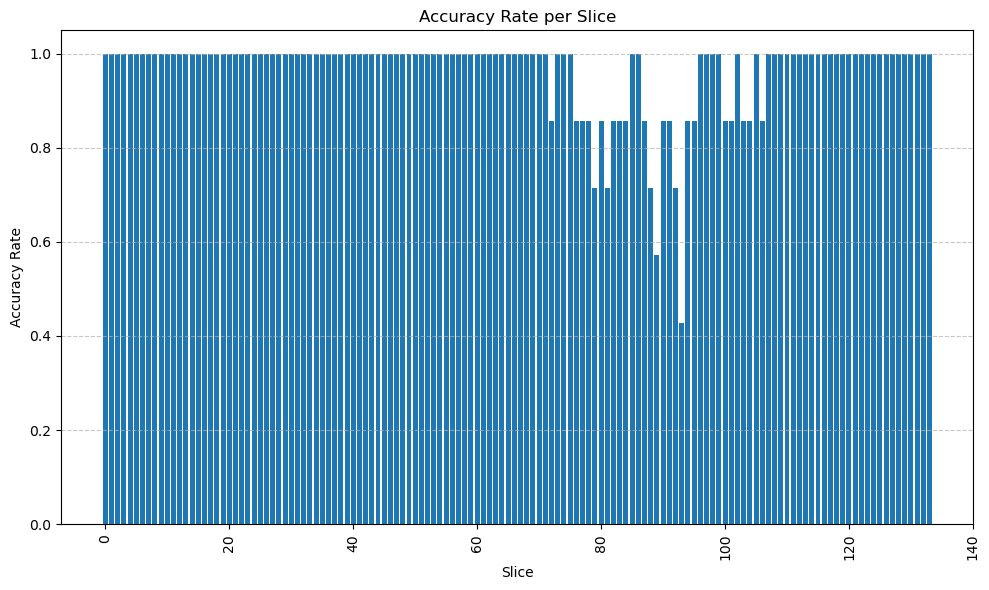

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is called 'df'

# Assuming 'accurate' column represents prediction accuracy (True/False or 1/0)
# Calculate accuracy per slice (assuming 'accurate' is a boolean or numeric column representing accuracy)
accuracy_rate = df.groupby('slice')['accurate'].mean().sort_index()

# Generate the bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(x=accuracy_rate.index, height=accuracy_rate.values)
plt.xlabel('Slice')
plt.ylabel('Accuracy Rate')
plt.title('Accuracy Rate per Slice')

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)  # Adjust rotation angle if needed
plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<BarContainer object of 134 artists>

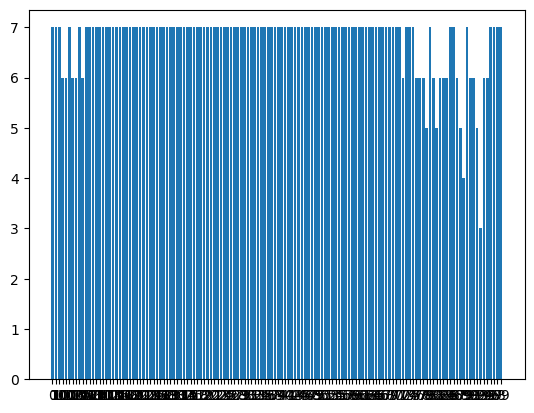